In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])

Name: /physical_device:GPU:0   Type: GPU


In [4]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(raw_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

# Normalize the input features using the sklearn StandardScaler.
# This will set the mean to 0 and standard deviation to 1.
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 30)
Validation features shape: (45569, 30)
Test features shape: (56962, 30)


In [6]:
neg, pos = np.bincount(train_labels)
total = neg + pos
print('{} positive samples out of {} training samples ({:.2f}% of total)'.format(
    pos, total, 100 * pos / total))

305 positive samples out of 182276 training samples (0.17% of total)


In [7]:
def make_model():
  model = keras.Sequential([
      keras.layers.Dense(256, activation='relu',
                         input_shape=(train_features.shape[-1],)),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  metrics = [
      keras.metrics.Accuracy(name='accuracy'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
  ]

  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=metrics)
  
  return model

In [8]:
model = make_model()

EPOCHS = 10
BATCH_SIZE = 2048

history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels))

Train on 182276 samples, validate on 45569 samples
Epoch 1/10
182276/182276 [==============================] - 3s 16us/sample - loss: 0.0445 - accuracy: 0.0263 - tp: 4.0000 - fp: 2092.0000 - tn: 179879.0000 - fn: 301.0000 - precision: 0.0019 - recall: 0.0131 - auc: 0.6965 - val_loss: 0.0069 - val_accuracy: 0.0143 - val_tp: 18.0000 - val_fp: 3.0000 - val_tn: 45486.0000 - val_fn: 62.0000 - val_precision: 0.8571 - val_recall: 0.2250 - val_auc: 0.8603
Epoch 2/10
182276/182276 [==============================] - 1s 5us/sample - loss: 0.0037 - accuracy: 0.0198 - tp: 183.0000 - fp: 32.0000 - tn: 181939.0000 - fn: 122.0000 - precision: 0.8512 - recall: 0.6000 - auc: 0.9313 - val_loss: 0.0060 - val_accuracy: 0.0161 - val_tp: 54.0000 - val_fp: 12.0000 - val_tn: 45477.0000 - val_fn: 26.0000 - val_precision: 0.8182 - val_recall: 0.6750 - val_auc: 0.8856
Epoch 3/10
182276/182276 [==============================] - 1s 4us/sample - loss: 0.0029 - accuracy: 0.0269 - tp: 241.0000 - fp: 41.0000 - tn: 1819

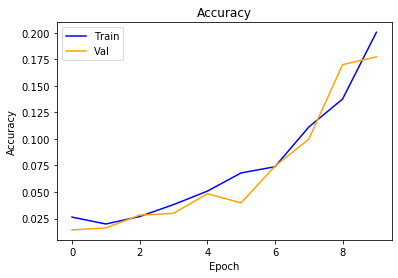

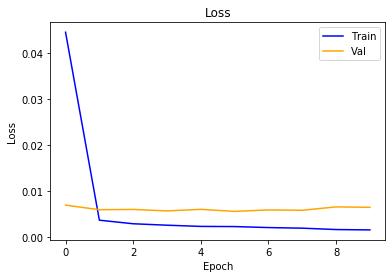

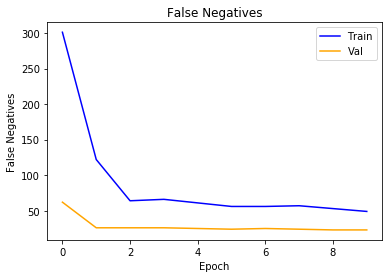

In [9]:
epochs = range(EPOCHS)

plt.title('Accuracy')
plt.plot(epochs,  history.history['accuracy'], color='blue', label='Train')
plt.plot(epochs, history.history['val_accuracy'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Loss')
plt.plot(epochs, history.history['loss'], color='blue', label='Train')
plt.plot(epochs, history.history['val_loss'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

_ = plt.figure()
plt.title('False Negatives')
plt.plot(epochs, history.history['fn'], color='blue', label='Train')
plt.plot(epochs, history.history['val_fn'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('False Negatives')
plt.legend()

In [10]:
results = model.evaluate(test_features, test_labels, verbose=2)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)

56962/1 - 8s - loss: 0.0015 - accuracy: 0.1768 - tp: 91.0000 - fp: 14.0000 - tn: 56841.0000 - fn: 16.0000 - precision: 0.8667 - recall: 0.8505 - auc: 0.9530
loss :  0.002902992959023148
accuracy :  0.17680208
tp :  91.0
fp :  14.0
tn :  56841.0
fn :  16.0
precision :  0.8666667
recall :  0.85046726
auc :  0.95302904


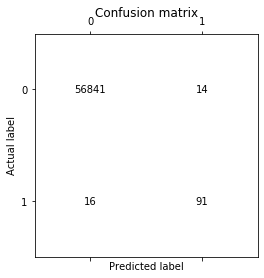

Legitimate Transactions Detected (True Negatives):  56841
Legitimate Transactions Incorrectly Detected (False Positives):  14
Fraudulent Transactions Missed (False Negatives):  16
Fraudulent Transactions Detected (True Positives):  91
Total Fraudulent Transactions:  107


In [11]:
predicted_labels = model.predict(test_features)
cm = confusion_matrix(test_labels, np.round(predicted_labels))

plt.matshow(cm, alpha=0)
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center')
    
plt.show()

print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [12]:
weight_for_0 = 1 / neg
weight_for_1 = 1 / pos

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2e}'.format(weight_for_0))
print('Weight for class 1: {:.2e}'.format(weight_for_1))

Weight for class 0: 5.50e-06
Weight for class 1: 3.28e-03


In [13]:
weighted_model = make_model()

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    class_weight=class_weight)

Train on 182276 samples, validate on 45569 samples
Epoch 1/10
182276/182276 [==============================] - 3s 14us/sample - loss: 4.7503e-06 - accuracy: 1.6459e-05 - tp: 270.0000 - fp: 66244.0000 - tn: 115727.0000 - fn: 35.0000 - precision: 0.0041 - recall: 0.8852 - auc: 0.9046 - val_loss: 3.8651e-06 - val_accuracy: 0.0000e+00 - val_tp: 62.0000 - val_fp: 305.0000 - val_tn: 45184.0000 - val_fn: 18.0000 - val_precision: 0.1689 - val_recall: 0.7750 - val_auc: 0.9034
Epoch 2/10
182276/182276 [==============================] - 1s 5us/sample - loss: 2.5629e-06 - accuracy: 2.2493e-04 - tp: 269.0000 - fp: 1943.0000 - tn: 180028.0000 - fn: 36.0000 - precision: 0.1216 - recall: 0.8820 - auc: 0.9582 - val_loss: 3.3338e-06 - val_accuracy: 3.2917e-04 - val_tp: 63.0000 - val_fp: 783.0000 - val_tn: 44706.0000 - val_fn: 17.0000 - val_precision: 0.0745 - val_recall: 0.7875 - val_auc: 0.9219
Epoch 3/10
182276/182276 [==============================] - 1s 5us/sample - loss: 1.7627e-06 - accuracy: 4.05

In [14]:
weighted_results = weighted_model.evaluate(test_features, test_labels, verbose=2)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)

56962/1 - 9s - loss: 0.0244 - accuracy: 0.0029 - tp: 98.0000 - fp: 498.0000 - tn: 56357.0000 - fn: 9.0000 - precision: 0.1644 - recall: 0.9159 - auc: 0.9790
loss :  0.0408904792506222
accuracy :  0.0028615568
tp :  98.0
fp :  498.0
tn :  56357.0
fn :  9.0
precision :  0.16442953
recall :  0.91588783
auc :  0.97901714


In [15]:
# with default args this will oversample the minority class to have an equal
# number of observations
smote = SMOTE()
res_features, res_labels = smote.fit_sample(train_features, train_labels)

res_neg, res_pos = np.bincount(res_labels)
res_total = res_neg + res_pos
print('{} positive samples out of {} training samples ({:.2f}% of total)'.format(
    res_pos, res_total, 100 * res_pos / res_total))

181971 positive samples out of 363942 training samples (50.00% of total)


In [16]:
resampled_model = make_model()

resampled_history = resampled_model.fit(
    res_features,
    res_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels))

Train on 363942 samples, validate on 45569 samples
Epoch 1/10
363942/363942 [==============================] - 3s 9us/sample - loss: 0.0497 - accuracy: 0.3179 - tp: 178867.0000 - fp: 4095.0000 - tn: 177876.0000 - fn: 3104.0000 - precision: 0.9776 - recall: 0.9829 - auc: 0.9985 - val_loss: 0.0183 - val_accuracy: 0.4070 - val_tp: 63.0000 - val_fp: 105.0000 - val_tn: 45384.0000 - val_fn: 17.0000 - val_precision: 0.3750 - val_recall: 0.7875 - val_auc: 0.9041
Epoch 2/10
363942/363942 [==============================] - 2s 4us/sample - loss: 0.0043 - accuracy: 0.4826 - tp: 181957.0000 - fp: 265.0000 - tn: 181706.0000 - fn: 14.0000 - precision: 0.9985 - recall: 0.9999 - auc: 0.9998 - val_loss: 0.0167 - val_accuracy: 0.7959 - val_tp: 60.0000 - val_fp: 43.0000 - val_tn: 45446.0000 - val_fn: 20.0000 - val_precision: 0.5825 - val_recall: 0.7500 - val_auc: 0.8993
Epoch 3/10
363942/363942 [==============================] - 2s 4us/sample - loss: 0.0027 - accuracy: 0.5592 - tp: 181964.0000 - fp: 147.0

In [17]:
resampled_results = resampled_model.evaluate(test_features, test_labels, verbose=2)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)

56962/1 - 8s - loss: 0.0058 - accuracy: 0.9827 - tp: 93.0000 - fp: 29.0000 - tn: 56826.0000 - fn: 14.0000 - precision: 0.7623 - recall: 0.8692 - auc: 0.9391
loss :  0.01166205530452411
accuracy :  0.98267263
tp :  93.0
fp :  29.0
tn :  56826.0
fn :  14.0
precision :  0.76229507
recall :  0.86915886
auc :  0.9391026
